# Taller I: Speech Characterization

En este taller la idea es que generen un notebook de Jupyter donde obtengan una sñal devoz, a partir del microfono de su computador, en donde deben decir las vocales. Esta señal debe ser procesada utilizando el espectrograma, y el Me-Spectrograma para obtener una caracterización de los fonemas de las vocales.

Por medio de procesamiento del espectrograma deberan identificar los intervalos donde se pronunci un fonema, y realizar una grafica de la firma espectral de ese fonema junto con su desviación estandar.

Para realizar la obtención de la señal de voz pueden utulizar el paquete *sounddevice* de python. Las funciones para el espectrograma y el mel-spectrograma pueden encontrarlas en diferentes librerias de python, no es necesario qu elas implementen.

Para ayudar a guiar el desarrollo del taller, les adjunto un código en Matlab que reliza estas funciones.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy as sc
from scipy import signal
from scipy.fft import fftshift

import librosa
import librosa.display

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import soundfile as sf

Primero, se configura define parametros importantes para conseguir el audio. El archivo 'output.wav' ya se encuentra grabado así que solo será necesario leerlo.

In [3]:
fs = 8000 # Numero de muestras por segundo
nBits = 16 # Numero de bits por muestra del audio
nChannels = 1 # Numero de canales
ID = -1
seconds = 5 # Duracion de la grabacion

In [4]:
y_aux, fs_aux = sf.read('output.wav') # leyendo el audio

In [5]:
# division de la señal por la desviacion estandar para tener una varianza de 1 de los datos
y = ((1/np.std(y_aux))*y_aux).reshape(len(y_aux))

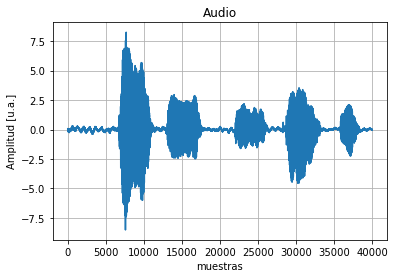

In [6]:
plt.plot(y)
plt.title("Audio")
plt.xlabel("muestras")
plt.ylabel("Amplitud [u.a.]")
plt.grid(True)
plt.show()

Vemos que la señal obtenida tiene 5 partes donde la amplitud es grande y que corresponden a cada vocal pronunciada. Las partes con amplitud muy baja corresponden a cuando no se pronuncia nada pero tienen el ruido de fondo del audio. El objetivo ahora es obtener el spectrograma sobre cada vocal. 

In [7]:
# Opcional: para reproducir audio
sd.play(y,fs)

In [8]:
# Como fs representa la cantidad de muestras en un segundo, calculamos 
# el numero de muestras para 20 ms 
len_win = np.fix(0.02*fs)
# Ventana de Hamming
wind = np.hanning(len_win)
# Definimos un overlap de 10ms entre 2 ventanas consecutivos
len_over = np.fix(0.01*fs) # Defining number of samples for an overlap of 10ms between consecutive windows.
Nfft = 512 # Number of points for the FFT

A continuación creamos el spectrograma a partir del audio obtenido. La función usada retorna la matriz de valores de la amplitud de la señal y adicionalmente un arreglo del tiempo que dura la señal junto con un arreglo de frecuencias.

In [9]:
f,t,Syy = signal.spectrogram(y,fs,window=wind, nperseg=len_win,noverlap=len_over,nfft=Nfft)

In [10]:
Sw = np.abs(Syy) # calculando el val. absoluto del spectrograma
F = f.reshape(len(f),1) @ np.ones([1,len(t)]) # matriz de frecuencias
T = np.ones([len(f),1]) @ t.reshape(1,len(t)) # matriz de tiempos

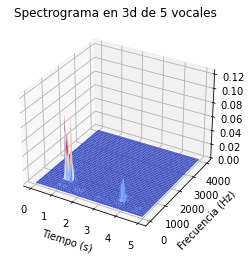

In [11]:
# Grafica de spectrograma
fig = plt.figure()
ax = fig.gca(projection="3d")

surf = ax.plot_surface(T,F,Syy,cmap=cm.coolwarm)
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
#plt.zlabel("Intensidad") # revisar
plt.title("Spectrograma en 3d de 5 vocales")
plt.show()

Vemos que la amplitud que más resalta es la de la vocal "a" seguida de la amplitud de la vocal "u". El resto de vocales tienen una amplitud muy baja sin embargo veremos más adelante que lo anterior no es un obstaculo para obtener la firma espectral de cada vocal.


## Calculo de Mel-spectrograma
A continuación se calcula el Mel-Spectrograma de la señal. Este espectrograma usa la escala de mel que a intervalos representa frecuencias de diferente orden. la librería librosa sirve mucho para graficar Mel-spectrogramas sin embargo no devueve un arreglo con las frecuencias asociadas. 

In [12]:
# Calculo de Mel-Spectograma
Sm = librosa.feature.melspectrogram(y=y, sr=fs, n_fft=Nfft)

In [13]:
# Se divide entre 4 para que quede la misma cantidad de puntos de frecuencias.
fm = np.arange(0, Nfft / 4) * fs / Nfft

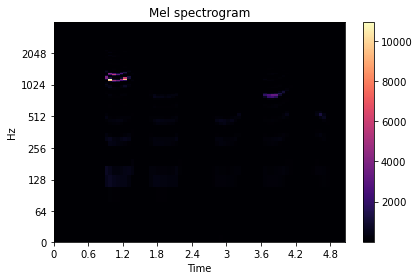

In [14]:
fig=plt.figure()
#librosa.display.specshow(Sm,y_axis='mel',x_axis='time')
librosa.display.specshow(Sm, sr=fs, hop_length=Nfft, x_axis='time', y_axis='log')
plt.colorbar() #Confirmar unidad
plt.title("Mel spectrogram")
plt.tight_layout()

In [15]:
# Detectando cambios en los fonemas
# con el spectrograma
D_Sw = np.sqrt(np.sum((Sw[:,1:] - Sw[:,0:-1])**2,axis=0))
# con el Mel-Spectrograma
D_Sm = np.sqrt(np.sum((Sm[:,1:] - Sm[:,0:-1])**2,axis=0))

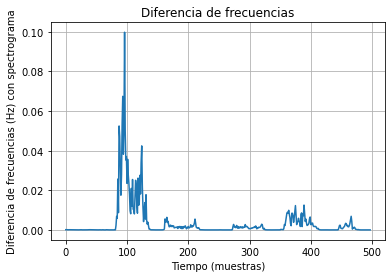

In [16]:
fig = plt.figure()
plt.grid(True)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia de frecuencias (Hz) con spectrograma") # REVISAR
plt.title("Diferencia de frecuencias")
plt.plot(D_Sw);

Vemos que la primera vocal tiene ubica su diferencia de frecuencias entre las mueztras 80 a 136, la e de la 161 a la 220, la i de 272 a la 324, la o de 355 a 412 muestras y la u de 444 a 475 muestras.

In [17]:
a_s = np.array(range(80,136))
e_s = np.array(range(161,220))
i_s = np.array(range(272,324))
o_s = np.array(range(355,412))
u_s = np.array(range(444,475))

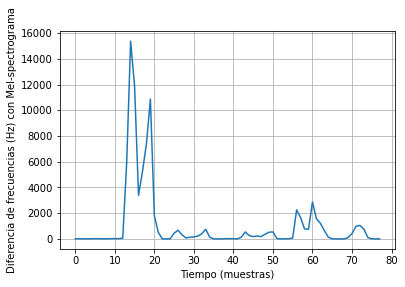

In [18]:
# Graficando con Mel-Spectrograma
fig = plt.figure()
plt.grid(True)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia de frecuencias (Hz) con Mel-spectrograma") # REVISAR
plt.plot(D_Sm);

Analogamente a lo que teniamos en la anterior grafica podemos ver que aqui se resaltan los valores de las vocales, entonces podemos tomar los siguientes valores de tal forma que sepamos en el tiempo donde se encuentran, es decir:

1. a: 12-22
2. e: 24-36
3. i: 40-51
4. o: 54-65
5. u: 68-75

In [19]:
a_m = np.array(range(12,22))
e_m = np.array(range(24,36))
i_m = np.array(range(40,51))
o_m = np.array(range(54,65))
u_m = np.array(range(68,75))

Luego de tener los valores en donde se encuentran las vocales en los respectivos histogramas, debemos seleccionar de nuestra matriz dichos valores para realizar el calculo de la varianza y media para cada vocal, ya que de esta forma podemos ver como se identifican dichas vocales.

Text(0.5, 1.0, 'Espectro de frecuencias con spectrograma para vocal A')

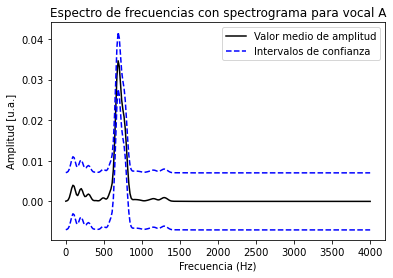

In [20]:
# plots de cada señal de los diferentes fonemas usando
# el spectrograma
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(f,np.mean(Sw[:,a_s+1],axis=1),color='k')# REVISAR
plt.plot(f,np.mean(Sw[:,a_s+1],axis=1)+np.std(Sw[:,a_s+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(f,np.mean(Sw[:,a_s+1],axis=1)-np.std(Sw[:,a_s+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con spectrograma para vocal A")

Text(0.5, 1.0, 'Espectro de frecuencias con spectrograma para vocal E')

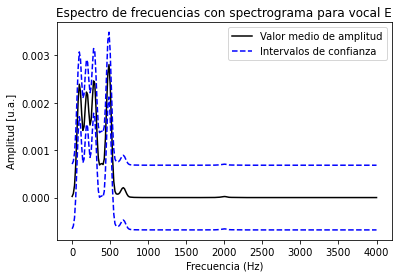

In [21]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(f,np.mean(Sw[:,e_s+1],axis=1),color='k')# REVISAR
plt.plot(f,np.mean(Sw[:,e_s+1],axis=1)+np.std(Sw[:,e_s+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(f,np.mean(Sw[:,e_s+1],axis=1)-np.std(Sw[:,e_s+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con spectrograma para vocal E")

Text(0.5, 1.0, 'Espectro de frecuencias con spectrograma para vocal I')

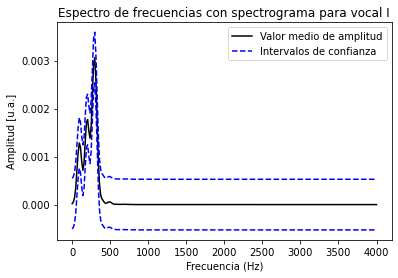

In [22]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(f,np.mean(Sw[:,i_s+1],axis=1),color='k')# REVISAR
plt.plot(f,np.mean(Sw[:,i_s+1],axis=1)+np.std(Sw[:,i_s+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(f,np.mean(Sw[:,i_s+1],axis=1)-np.std(Sw[:,i_s+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con spectrograma para vocal I")

Text(0.5, 1.0, 'Espectro de frecuencias con spectrograma para vocal O')

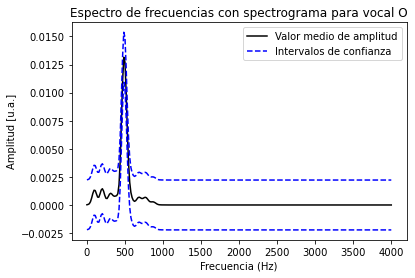

In [23]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(f,np.mean(Sw[:,o_s+1],axis=1),color='k')# REVISAR
plt.plot(f,np.mean(Sw[:,o_s+1],axis=1)+np.std(Sw[:,o_s+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(f,np.mean(Sw[:,o_s+1],axis=1)-np.std(Sw[:,o_s+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con spectrograma para vocal O")

Text(0.5, 1.0, 'Espectro de frecuencias con spectrograma para vocal U')

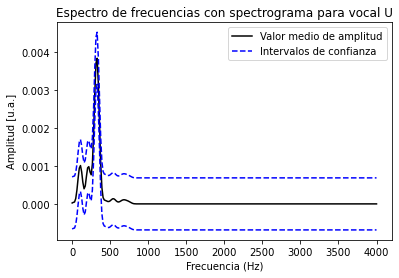

In [24]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(f,np.mean(Sw[:,u_s+1],axis=1),color='k')# REVISAR
plt.plot(f,np.mean(Sw[:,u_s+1],axis=1)+np.std(Sw[:,u_s+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(f,np.mean(Sw[:,u_s+1],axis=1)-np.std(Sw[:,u_s+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con spectrograma para vocal U")

Text(0.5, 1.0, 'Espectro de frecuencias con Mel-spectrograma para vocal A')

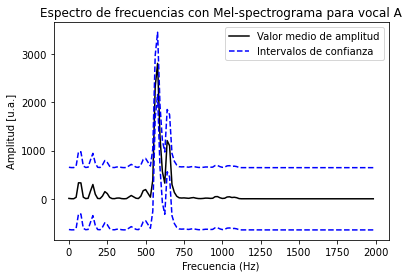

In [25]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(fm,np.mean(Sm[:,a_m+1],axis=1),color='k')# REVISAR
plt.plot(fm,np.mean(Sm[:,a_m+1],axis=1)+np.std(Sm[:,a_m+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(fm,np.mean(Sm[:,a_m+1],axis=1)-np.std(Sm[:,a_m+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con Mel-spectrograma para vocal A")

Text(0.5, 1.0, 'Espectro de frecuencias con Mel-spectrograma para vocal E')

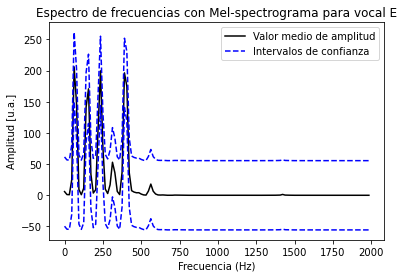

In [26]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(fm,np.mean(Sm[:,e_m+1],axis=1),color='k')# REVISAR
plt.plot(fm,np.mean(Sm[:,e_m+1],axis=1)+np.std(Sm[:,e_m+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(fm,np.mean(Sm[:,e_m+1],axis=1)-np.std(Sm[:,e_m+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con Mel-spectrograma para vocal E")

Text(0.5, 1.0, 'Espectro de frecuencias con Mel-spectrograma para vocal I')

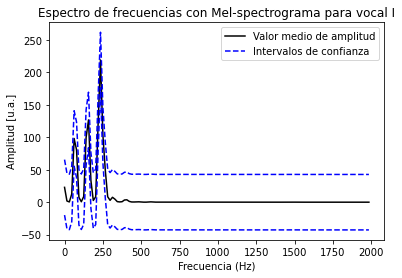

In [27]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(fm,np.mean(Sm[:,i_m+1],axis=1),color='k')# REVISAR
plt.plot(fm,np.mean(Sm[:,i_m+1],axis=1)+np.std(Sm[:,i_m+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(fm,np.mean(Sm[:,i_m+1],axis=1)-np.std(Sm[:,i_m+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con Mel-spectrograma para vocal I")

Text(0.5, 1.0, 'Espectro de frecuencias con Mel-spectrograma para vocal O')

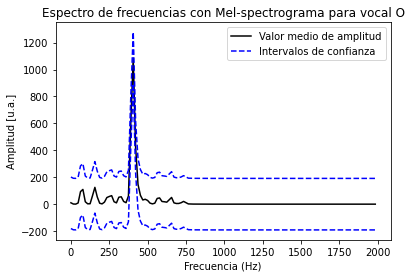

In [28]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(fm,np.mean(Sm[:,o_m+1],axis=1),color='k')# REVISAR
plt.plot(fm,np.mean(Sm[:,o_m+1],axis=1)+np.std(Sm[:,o_m+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(fm,np.mean(Sm[:,o_m+1],axis=1)-np.std(Sm[:,o_m+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con Mel-spectrograma para vocal O")

Text(0.5, 1.0, 'Espectro de frecuencias con Mel-spectrograma para vocal U')

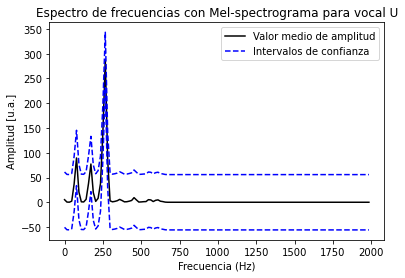

In [29]:
fig = plt.figure()
#plt.subplots(nrows=1,ncols=1)
plt.plot(fm,np.mean(Sm[:,u_m+1],axis=1),color='k')# REVISAR
plt.plot(fm,np.mean(Sm[:,u_m+1],axis=1)+np.std(Sm[:,u_m+1]),color='b',linestyle="dashed")# REVISAR
plt.plot(fm,np.mean(Sm[:,u_m+1],axis=1)-np.std(Sm[:,u_m+1]),color='b',linestyle="dashed")
plt.legend(["Valor medio de amplitud","Intervalos de confianza"])
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [u.a.]")
plt.title("Espectro de frecuencias con Mel-spectrograma para vocal U")